In [1]:
import deeplabcut as dlc
import numpy as np
import pandas as pd
import cv2
import struct
import matplotlib.pyplot as plt
import pandas as pd
import os

Loading DLC 2.3.0...


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Settings
dlc_model = r'D:\DLC\Fountain_topview-HY-2023-09-07\config.yaml'
frame_interval = 100
video_path_all = ['20230920-15-59-21.000.seq',
    '20230920-16-41-23.000.seq',
    '20230920-17-18-35.000.seq',
    '20230920-22-42-27.000.seq']

dir_temp = r'F:\Fountain\Videos\20230920\Temp/'
dir_image = os.path.join(dir_temp, 'Image')
p_thres = 0.9
v_angle_thres = 0.5*np.pi

In [3]:
def readSeq(video_path, frame):
    fid = open(video_path, 'rb')
    fidIdx = open(video_path + '.idx', 'rb')

    if frame == 1:
        readStart = 1028
        fidIdx.seek(8)
        imageBufferSize = int.from_bytes(fidIdx.read(4), byteorder='little', signed=False)
    else:
        readStartIdx = frame*24
        fidIdx.seek(readStartIdx)
        readStart = int.from_bytes(fidIdx.read(8), byteorder='little', signed=False) + 4
        imageBufferSize = int.from_bytes(fidIdx.read(4), byteorder='little', signed=False)


    fid.seek(readStart)

    JpegSEQ = np.frombuffer(fid.read(imageBufferSize), dtype=np.uint8)

    I = cv2.imdecode(JpegSEQ, np.uint8(0))

    fid.close()
    fidIdx.close()
    
    return I

def read_header(video_path):
    ifile = open(video_path, 'rb')

    feed = ifile.read(4)
    norpix = ifile.read(24)
    version = struct.unpack('@i', ifile.read(4))
    descr = ifile.read(512)
    length = struct.unpack('@i', ifile.read(4))
    assert (length != 1024)
    params = [struct.unpack('@i', ifile.read(4))[0] for i in range(0, 9)]
    fps = struct.unpack('@d', ifile.read(8))
    # skipping the rest
    ifile.read(432)
    image_ext = {100: 'raw', 102: 'jpg', 201: 'jpg', 1: 'png', 2: 'png'}

    ifile.close()
    return {'w': params[0], 'h': params[1],
            'bdepth': params[2],
            'ext': image_ext[params[5]],
            'format': params[5],
            'size': params[4],
            'true_size': params[8],
            'num_frames': params[6]}

def create_images(img, frame, dir_image):
    if not os.path.exists(dir_image):
        os.makedirs(dir_image)
    filename = os.path.join(dir_image, str(frame).zfill(6)+'.png')
    cv2.imwrite(filename, img)

def get_angle(pos_left_ear, pos_right_ear):
    angle = np.arctan2(pos_left_ear[1]-pos_right_ear[1], pos_left_ear[0]-pos_right_ear[0])
    return angle

def sub_angle(angle1, angle2):
    d = angle2-angle1
    if d>np.pi:
        d = d-2*np.pi
    elif d<-np.pi:
        d = d+2*np.pi
    return d

def merge_dataframe(df_all):
    df_out = pd.concat(df_all)
    df_out = df_out.sort_values(by=('bodyparts','coords'))
    return df_out

def add_new_folder(df, image_dir_new, dlc_model):
    dlc.analyze_time_lapse_frames(dlc_model, image_dir_new, frametype='png', save_as_csv=True)
    folder = os.path.basename(os.path.dirname(image_dir_new))

    csv_filename = get_full_filename(image_dir_new, '.csv')
    df_new = pd.read_csv(csv_filename, header=[1,2])
    return merge_dataframe((df, df_new))

def find_next_good_frame(p_head, idx):
    for k in range(idx+1, len(p_head)):
        if p_head[k]>=p_thres:
            return k
    return -1

def find_nearest_good_frames(p_head, idx):
    fa = -1
    fb = -1
    for k in range(idx-1, -1, -1):
        if p_head[k]>=p_thres:
            fa = k
            break
    for k in range(idx+1, len(p_head)):
        if p_head[k]>=p_thres:
            fb = k
            break
    return fa, fb

def find_new_frames_to_analyze(df, p_thres, v_angle_thres, n_points=4, n_frames=50):
    image_filenames = df['bodyparts']['coords'].to_list()
    idx_frame = np.array([int(x[:-4]) for x in image_filenames])

    pos_left_ear = np.stack((df['left_ear']['x'].to_numpy(),df['left_ear']['y'].to_numpy()), axis=0)
    pos_right_ear = np.stack((df['right_ear']['x'].to_numpy(),df['right_ear']['y'].to_numpy()), axis=0)

    ll = df['left_ear']['likelihood'].to_numpy()
    lr = df['right_ear']['likelihood'].to_numpy()

    p_head = np.min(np.stack((ll, lr), axis=0), axis=0)

    new_frames_to_analyze = []

    for k in range(len(p_head)):
        if p_head[k]<p_thres:
            fa, fb = find_nearest_good_frames(p_head, k)
            if fa<0 or fb<0:
                continue

            d_angle = sub_angle(get_angle(pos_left_ear[:, fa], pos_right_ear[:, fa]), get_angle(pos_left_ear[:, fb], pos_right_ear[:, fb]))
            if idx_frame[fb]-idx_frame[fa]<=n_frames and np.abs(d_angle)<v_angle_thres:
                continue

            # sample 4 points in between fa and fb
            is_point_added = False
            point_added = 0
            while (not is_point_added) and point_added<=2: 
                frames_sample = np.linspace(idx_frame[fa], idx_frame[fb], n_points+point_added+1).astype(int)
                point_added += 1
                for frame in frames_sample:
                    if frame in idx_frame:
                        continue
                    else:
                        new_frames_to_analyze.append(frame)
                        is_point_added = True

        else:
            fa = k
            fb = find_next_good_frame(p_head, k)
            if fb<0:
                continue

            d_angle = sub_angle(get_angle(pos_left_ear[:, fa], pos_right_ear[:, fa]), get_angle(pos_left_ear[:, fb], pos_right_ear[:, fb]))
            if np.abs(d_angle)<v_angle_thres:
                continue
            
            # sample 4 points in between fa and fb
            is_point_added = False
            point_added = 0
            while (not is_point_added) and point_added<=2: 
                frames_sample = np.linspace(idx_frame[fa], idx_frame[fb], n_points+point_added+1).astype(int)
                point_added += 1
                for frame in frames_sample:
                    if frame in idx_frame:
                        continue
                    else:
                        new_frames_to_analyze.append(frame)
                        is_point_added = True

    return sorted(set(new_frames_to_analyze))

def get_full_filename(dir_image, extension):
    filenames = os.listdir(dir_image)
    filenames = [x for x in filenames if x.endswith(extension)]
    filenames = [os.path.join(dir_image, x) for x in filenames]
    if len(filenames)>1:
        os.error('More than one file with extension '+extension+' in '+dir_image)
    return filenames[0]

def analyze_segment(segment_num, video_path, dir_temp = './Temp/'):
    meta = read_header(video_path)
    frames_to_analyze = np.arange(1, meta['num_frames'], frame_interval).tolist()
    dir_image = os.path.join(dir_temp, 'Image_Segment'+str(segment_num))
    
    for frame in frames_to_analyze:
        temp_filename = os.path.join(dir_image, str(frame).zfill(6)+'.png')
        if os.path.isfile(temp_filename):
            continue
        I = readSeq(video_path, frame)
        create_images(I, frame, dir_image)  

    dlc.analyze_time_lapse_frames(dlc_model, dir_image, frametype='png', save_as_csv=True)
    csv_filename = get_full_filename(dir_image, 'csv')
    df = pd.read_csv(csv_filename, header=[1,2])

    new_frames_to_analyze = find_new_frames_to_analyze(df, p_thres, v_angle_thres)
    count = 1
    while len(new_frames_to_analyze)>0:
        dir_new_frames = os.path.join(dir_temp,'New'+str(count)+'_Segment'+str(segment_num)+'/')
        if not os.path.exists(dir_new_frames):
            os.makedirs(dir_new_frames)

        for frame in new_frames_to_analyze:
            temp_filename = dir_new_frames+str(frame).zfill(6)+'.png'
            if os.path.isfile(temp_filename):
                continue
            I = readSeq(video_path, frame)
            create_images(I, frame, dir_new_frames)

        df = add_new_folder(df, dir_new_frames, dlc_model)
        count = count+1

        new_frames_to_analyze = find_new_frames_to_analyze(df, p_thres, v_angle_thres)

    # Get the final result
    pos_left_ear = np.stack((df['left_ear']['x'].to_numpy(),df['left_ear']['y'].to_numpy()), axis=0)
    pos_right_ear = np.stack((df['right_ear']['x'].to_numpy(),df['right_ear']['y'].to_numpy()), axis=0)

    ll = df['left_ear']['likelihood'].to_numpy()
    lr = df['right_ear']['likelihood'].to_numpy()

    p_head = np.min(np.stack((ll, lr), axis=0), axis=0)
    angle = np.array([get_angle(pos_left_ear[:,k], pos_right_ear[:,k]) for k in range(len(p_head))])

    image_filenames = df['bodyparts']['coords'].to_list()
    idx_frame = np.array([int(x[:-4]) for x in image_filenames])

    angle_good = angle[p_head>=p_thres]
    idx_good = idx_frame[p_head>=p_thres]
    print(len(angle_good), 'out of', len(angle), 'frames are good.')

    d_angle = np.array([sub_angle(angle_good[k-1], angle_good[k]) for k in range(1,len(angle_good))])
    d_angle = np.concatenate((np.array([0]), d_angle))

    d_idx = np.array([idx_good[k]-idx_good[k-1] for k in range(1,len(idx_good))])
    d_idx = np.concatenate((np.array([1]), d_idx))

    # filter the jumped point: d_angle>v_thres and d_idx==1
    idx_good_filtered = []
    for k in range(len(d_angle)):
        if not(np.abs(d_angle[k])>v_angle_thres and d_idx[k]==1):
            idx_good_filtered.append(k)

    print(len(idx_good_filtered), 'out of', len(angle_good), 'frames are good after filtering.')

    angle_filtered = angle_good[idx_good_filtered]
    idx_filtered = idx_good[idx_good_filtered]
    d_angle_filtered = np.array([sub_angle(angle_filtered[k-1], angle_filtered[k]) for k in range(1,len(angle_filtered))])
    d_angle_filtered = np.concatenate((np.array([0]), d_angle_filtered))

    d_idx_filtered = np.array([idx_filtered[k]-idx_filtered[k-1] for k in range(1,len(idx_filtered))])
    d_idx_filtered = np.concatenate((np.array([1]), d_idx_filtered))

    # save the data
    pos_left_ear_good = pos_left_ear[:,p_head>=p_thres]
    pos_right_ear_good = pos_right_ear[:,p_head>=p_thres]
    p_left_ear_good = ll[p_head>=p_thres]
    p_right_ear_good = lr[p_head>=p_thres]
    p_head_good = p_head[p_head>=p_thres]

    pos_left_ear_filtered = pos_left_ear_good[:,idx_good_filtered]
    pos_right_ear_filtered = pos_right_ear_good[:,idx_good_filtered]
    p_left_ear_filtered = p_left_ear_good[idx_good_filtered]
    p_right_ear_filtered = p_right_ear_good[idx_good_filtered]
    p_head_filtered = p_head_good[idx_good_filtered]


    df_out = pd.DataFrame({
        'frame_number': idx_filtered,
        'angle': angle_filtered, 
        'd_angle': d_angle_filtered,
        'turning_angle': np.cumsum(d_angle_filtered), 
        'x_left_ear': pos_left_ear_filtered[0,:],
        'y_left_ear': pos_left_ear_filtered[1,:], 
        'x_right_ear': pos_right_ear_filtered[0,:],
        'y_right_ear': pos_right_ear_filtered[1,:],
        'p_left_ear': p_left_ear_filtered,
        'p_right_ear': p_right_ear_filtered,
        'p_head': p_head_filtered})

    df_out.to_csv('turning_angle_segment'+str(segment_num)+'.csv', index=False)

    return df_out

Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/Image_Segment1
Frames already analyzed! F:\Fountain\Videos\20230920\Temp/Image_Segment1\Image_Segment1DLC_resnet50_Fountain_topviewSep7shuffle1_1030000.h5
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New1_Segment1/
Starting to extract posture
Overall # of frames:  841  found with (before cropping) frame dimensions:  880 704


100%|█████████▉| 840/841 [00:33<00:00, 24.91it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New1_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New2_Segment1/
Starting to extract posture
Overall # of frames:  834  found with (before cropping) frame dimensions:  880 704


100%|█████████▉| 830/834 [00:29<00:00, 28.23it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New2_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New3_Segment1/
Starting to extract posture
Overall # of frames:  692  found with (before cropping) frame dimensions:  880 704


100%|█████████▉| 690/692 [00:23<00:00, 28.94it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New3_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New4_Segment1/
Starting to extract posture
Overall # of frames:  616  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 610/616 [00:22<00:00, 27.44it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New4_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New5_Segment1/
Starting to extract posture
Overall # of frames:  493  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 490/493 [00:18<00:00, 27.21it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New5_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New6_Segment1/
Starting to extract posture
Overall # of frames:  296  found with (before cropping) frame dimensions:  880 704


 98%|█████████▊| 290/296 [00:10<00:00, 27.12it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New6_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New7_Segment1/
Starting to extract posture
Overall # of frames:  194  found with (before cropping) frame dimensions:  880 704


 98%|█████████▊| 190/194 [00:07<00:00, 26.60it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New7_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New8_Segment1/
Starting to extract posture
Overall # of frames:  113  found with (before cropping) frame dimensions:  880 704


 97%|█████████▋| 110/113 [00:04<00:00, 24.81it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New8_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New9_Segment1/
Starting to extract posture
Overall # of frames:  75  found with (before cropping) frame dimensions:  880 704


 93%|█████████▎| 70/75 [00:03<00:00, 22.75it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New9_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New10_Segment1/
Starting to extract posture
Overall # of frames:  41  found with (before cropping) frame dimensions:  880 704


 98%|█████████▊| 40/41 [00:01<00:00, 20.85it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New10_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New11_Segment1/
Starting to extract posture
Overall # of frames:  19  found with (before cropping) frame dimensions:  880 704


 53%|█████▎    | 10/19 [00:01<00:00,  9.36it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New11_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New12_Segment1/
Starting to extract posture
Overall # of frames:  6  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/6 [00:00<?, ?it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New12_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New13_Segment1/
Starting to extract posture
Overall # of frames:  3  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/3 [00:00<?, ?it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New13_Segment1/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
1994 out of 6023 frames are good.
1994 out of 1994 frames are good after filtering.


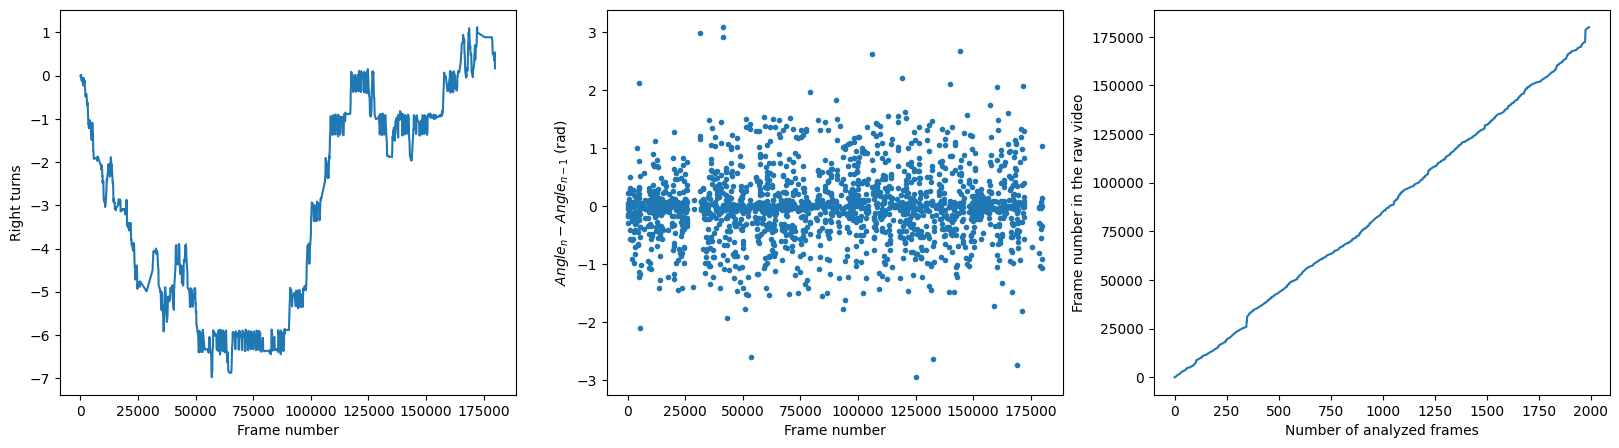

The animal made 0.17155150539117803 right turns in segment 1
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/Image_Segment2
Starting to extract posture
Overall # of frames:  1200  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 1188/1200 [00:41<00:00, 28.90it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/Image_Segment2...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New1_Segment2/
Starting to extract posture
Overall # of frames:  423  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 420/423 [00:14<00:00, 28.68it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New1_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New2_Segment2/
Starting to extract posture
Overall # of frames:  481  found with (before cropping) frame dimensions:  880 704


100%|█████████▉| 480/481 [00:17<00:00, 27.18it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New2_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New3_Segment2/
Starting to extract posture
Overall # of frames:  405  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 400/405 [00:14<00:00, 26.78it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New3_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New4_Segment2/
Starting to extract posture
Overall # of frames:  357  found with (before cropping) frame dimensions:  880 704


 98%|█████████▊| 350/357 [00:12<00:00, 26.94it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New4_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New5_Segment2/
Starting to extract posture
Overall # of frames:  290  found with (before cropping) frame dimensions:  880 704


 97%|█████████▋| 280/290 [00:10<00:00, 26.01it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New5_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New6_Segment2/
Starting to extract posture
Overall # of frames:  209  found with (before cropping) frame dimensions:  880 704


 96%|█████████▌| 200/209 [00:08<00:00, 24.82it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New6_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New7_Segment2/
Starting to extract posture
Overall # of frames:  138  found with (before cropping) frame dimensions:  880 704


 94%|█████████▍| 130/138 [00:05<00:00, 23.89it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New7_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New8_Segment2/
Starting to extract posture
Overall # of frames:  97  found with (before cropping) frame dimensions:  880 704


 93%|█████████▎| 90/97 [00:03<00:00, 22.96it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New8_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New9_Segment2/
Starting to extract posture
Overall # of frames:  46  found with (before cropping) frame dimensions:  880 704


 87%|████████▋ | 40/46 [00:02<00:00, 19.04it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New9_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New10_Segment2/
Starting to extract posture
Overall # of frames:  26  found with (before cropping) frame dimensions:  880 704


 77%|███████▋  | 20/26 [00:01<00:00, 14.47it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New10_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New11_Segment2/
Starting to extract posture
Overall # of frames:  23  found with (before cropping) frame dimensions:  880 704


 87%|████████▋ | 20/23 [00:01<00:00, 17.13it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New11_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New12_Segment2/
Starting to extract posture
Overall # of frames:  12  found with (before cropping) frame dimensions:  880 704


 83%|████████▎ | 10/12 [00:00<00:00, 12.63it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New12_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New13_Segment2/
Starting to extract posture
Overall # of frames:  2  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/2 [00:00<?, ?it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New13_Segment2/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
983 out of 3709 frames are good.
983 out of 983 frames are good after filtering.


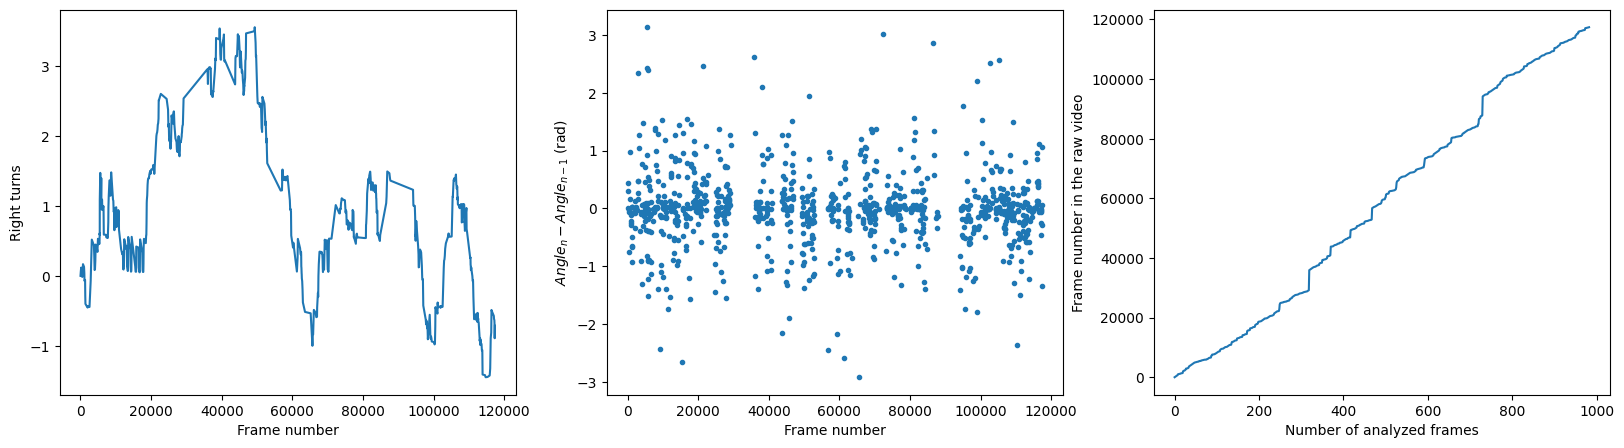

The animal made -0.7148667891033846 right turns in segment 2
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/Image_Segment3
Starting to extract posture
Overall # of frames:  1200  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 1188/1200 [00:40<00:00, 29.06it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/Image_Segment3...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New1_Segment3/
Starting to extract posture
Overall # of frames:  308  found with (before cropping) frame dimensions:  880 704


 97%|█████████▋| 300/308 [00:11<00:00, 27.14it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New1_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New2_Segment3/
Starting to extract posture
Overall # of frames:  338  found with (before cropping) frame dimensions:  880 704


 98%|█████████▊| 330/338 [00:11<00:00, 27.54it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New2_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New3_Segment3/
Starting to extract posture
Overall # of frames:  304  found with (before cropping) frame dimensions:  880 704


 99%|█████████▊| 300/304 [00:10<00:00, 28.18it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New3_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New4_Segment3/
Starting to extract posture
Overall # of frames:  209  found with (before cropping) frame dimensions:  880 704


 96%|█████████▌| 200/209 [00:07<00:00, 26.44it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New4_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New5_Segment3/
Starting to extract posture
Overall # of frames:  155  found with (before cropping) frame dimensions:  880 704


 97%|█████████▋| 150/155 [00:05<00:00, 26.45it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New5_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New6_Segment3/
Starting to extract posture
Overall # of frames:  102  found with (before cropping) frame dimensions:  880 704


 98%|█████████▊| 100/102 [00:03<00:00, 26.11it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New6_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New7_Segment3/
Starting to extract posture
Overall # of frames:  46  found with (before cropping) frame dimensions:  880 704


 87%|████████▋ | 40/46 [00:01<00:00, 20.56it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New7_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New8_Segment3/
Starting to extract posture
Overall # of frames:  37  found with (before cropping) frame dimensions:  880 704


 81%|████████  | 30/37 [00:01<00:00, 18.42it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New8_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New9_Segment3/
Starting to extract posture
Overall # of frames:  18  found with (before cropping) frame dimensions:  880 704


 56%|█████▌    | 10/18 [00:01<00:00,  9.81it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New9_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New10_Segment3/
Starting to extract posture
Overall # of frames:  8  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/8 [00:00<?, ?it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New10_Segment3/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
878 out of 2725 frames are good.
878 out of 878 frames are good after filtering.


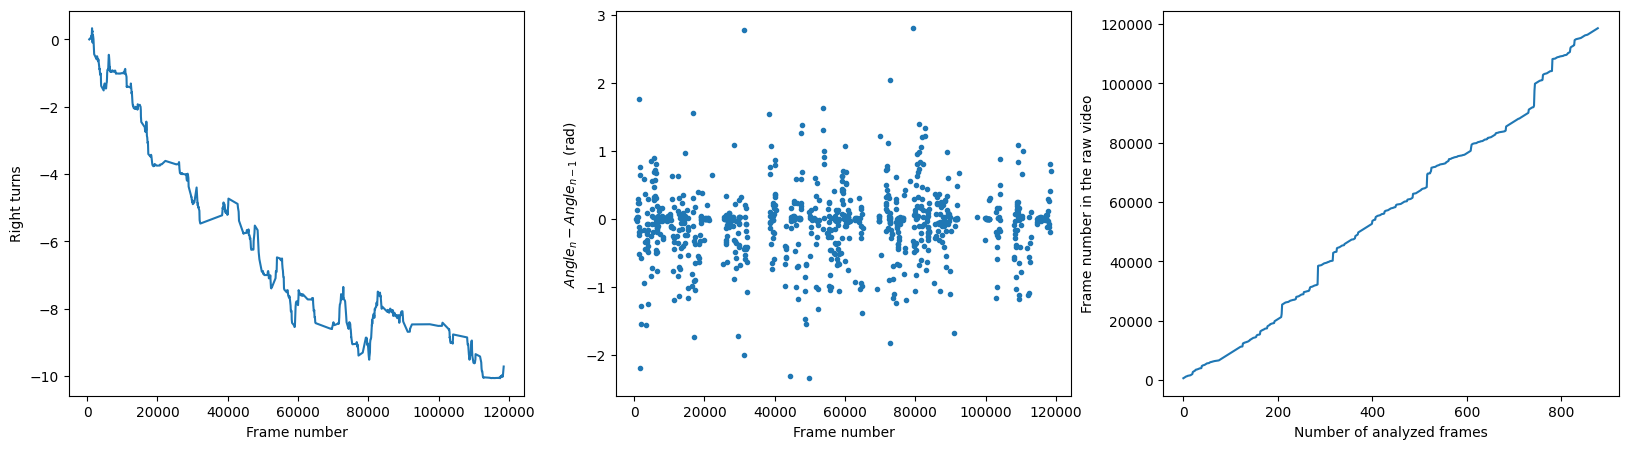

The animal made -9.718737327400301 right turns in segment 3
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/Image_Segment4
Starting to extract posture
Overall # of frames:  1215  found with (before cropping) frame dimensions:  880 704


100%|█████████▉| 1212/1215 [00:41<00:00, 29.11it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/Image_Segment4...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New1_Segment4/
Starting to extract posture
Overall # of frames:  584  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 580/584 [00:20<00:00, 28.69it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New1_Segment4/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New2_Segment4/
Starting to extract posture
Overall # of frames:  613  found with (before cropping) frame dimensions:  880 704


100%|█████████▉| 610/613 [00:21<00:00, 27.87it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New2_Segment4/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New3_Segment4/
Starting to extract posture
Overall # of frames:  512  found with (before cropping) frame dimensions:  880 704


100%|█████████▉| 510/512 [00:17<00:00, 29.03it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New3_Segment4/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New4_Segment4/
Starting to extract posture
Overall # of frames:  456  found with (before cropping) frame dimensions:  880 704


 99%|█████████▊| 450/456 [00:15<00:00, 28.76it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New4_Segment4/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New5_Segment4/
Starting to extract posture
Overall # of frames:  323  found with (before cropping) frame dimensions:  880 704


 99%|█████████▉| 320/323 [00:11<00:00, 28.23it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New5_Segment4/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New6_Segment4/
Starting to extract posture
Overall # of frames:  194  found with (before cropping) frame dimensions:  880 704


 98%|█████████▊| 190/194 [00:07<00:00, 27.02it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New6_Segment4/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New7_Segment4/
Starting to extract posture
Overall # of frames:  110  found with (before cropping) frame dimensions:  880 704


 91%|█████████ | 100/110 [00:04<00:00, 24.60it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New7_Segment4/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New8_Segment4/
Starting to extract posture
Overall # of frames:  59  found with (before cropping) frame dimensions:  880 704


 85%|████████▍ | 50/59 [00:02<00:00, 20.33it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New8_Segment4/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New9_Segment4/
Starting to extract posture
Overall # of frames:  24  found with (before cropping) frame dimensions:  880 704


 83%|████████▎ | 20/24 [00:01<00:00, 19.16it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New9_Segment4/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New10_Segment4/
Starting to extract posture
Overall # of frames:  14  found with (before cropping) frame dimensions:  880 704


 71%|███████▏  | 10/14 [00:00<00:00, 12.51it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New10_Segment4/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
Using snapshot-1030000 for model D:\DLC\Fountain_topview-HY-2023-09-07\dlc-models\iteration-0\Fountain_topviewSep7-trainset95shuffle1


c:\Users\jiumao\anaconda3\envs\deeplabcut\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all frames in the directory:  F:\Fountain\Videos\20230920\Temp/New11_Segment4/
Starting to extract posture
Overall # of frames:  6  found with (before cropping) frame dimensions:  880 704


  0%|          | 0/6 [00:00<?, ?it/s]


Saving results in F:\Fountain\Videos\20230920\Temp/New11_Segment4/...
Saving csv poses!
The folder was analyzed. Now your research can truly start!
If the tracking is not satisfactory for some frame, consider expanding the training set.
1233 out of 4110 frames are good.
1233 out of 1233 frames are good after filtering.


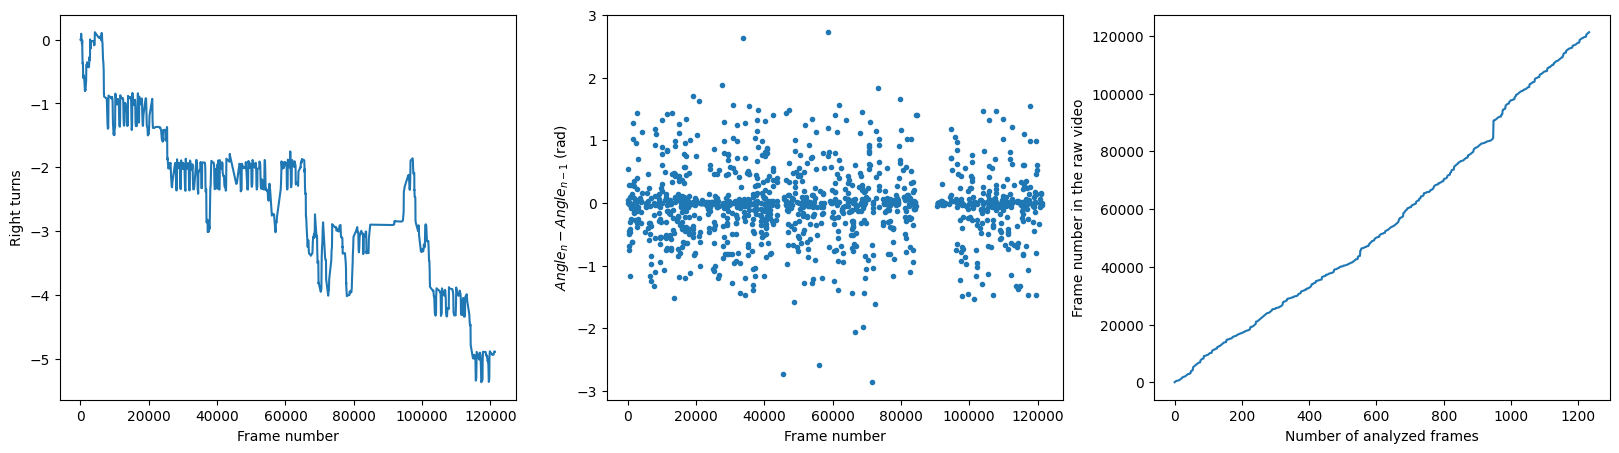

The animal made -4.893180682401702 right turns in segment 4


In [4]:
for k in range(len(video_path_all)):
    segment_num = k+1
    video_path = video_path_all[k]
    df_out = analyze_segment(segment_num, video_path, dir_temp)

    turning_angle = df_out['turning_angle'].to_numpy()
    d_angle = df_out['d_angle']

    plt.figure(figsize=(20,5))

    plt.subplot(1,3,1)
    plt.plot(df_out['frame_number'].to_numpy(), turning_angle/np.pi/2)
    plt.ylabel('Right turns')
    plt.xlabel('Frame number')

    plt.subplot(1,3,2)
    plt.plot(df_out['frame_number'].to_numpy(), d_angle, '.')
    plt.ylabel('$Angle_n - Angle_{n-1}$ (rad)', )
    plt.xlabel('Frame number')

    plt.subplot(1,3,3)
    plt.plot(df_out['frame_number'].to_numpy())
    plt.ylabel('Frame number in the raw video')
    plt.xlabel('Number of analyzed frames')

    plt.show()

    print('The animal made', turning_angle[-1]/np.pi/2, 'right turns in segment', segment_num)

In [5]:
# # make avi video
# fps = 10
# meta = read_header(video_path)
# frames = np.arange(1, meta['num_frames'], 10)

# fourcc = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G') # opencv3.0
# img = readSeq(video_path, 1)
# print(img.shape, fps, frames)
# videoWriter = cv2.VideoWriter('./TopVideo50Hz.avi', fourcc, 5, (img.shape[1], img.shape[0]), False)

# for frame in frames:
#     img = readSeq(video_path, frame)
#     videoWriter.write(img)

# videoWriter.release()